# Basic Idea

<b>We will create a semi-automatic algorithm that will alert to buy or sell in real-time.</br>
This will be done in 5 steps: </b></br>
1) Find a group of assets that move similarly with eachother over the past X periods of time. </br>
2) Find the best pair amongst them.</br>
3) Choose and calculate indicators to buy and sell.</br>
4) Alert buy / sell.</br>
5) Learn and improve the model, and test it.

# Basic Concepts
<b>Let's go over some of the concpets we'll use in this project:</b></br>
1) <u>Cointegration:</u> Similar to correlation. Means that the ratio between two series will vary around a mean. </br>  The two series, Y and X follow the follwing: Y = ⍺ X + e where ⍺ is the constant ratio and e is white noise</br>
In plain terms, it means that the ratio between the two financial time series will vary around a constant mean </br>
2) <u>Stationarity:</u> A stochastic process whose unconditional joint probability distribution does not change when shifted in time. </br>In plain terms, not time dependant. </br>
3) <u>Auto-corelation</u>: Similar to the correlation between two different time series, but autocorrelation uses the same time series twice: once in its original form and once lagged one or more time periods. Auto-correlation is some kind of Stationarity.</br>
4) <u>P-value</u>: The probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. </br> We will use it to test for conitegration. </br>

# Project requirements

In [17]:
from asyncio import threads
import seaborn
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint, adfuller
import yfinance as yf
from yahoo_fin.stock_info import get_data
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
from itertools import product

# Data that will be used
We will examine ETFs of tech companies.</br>
Our assumption is that each of them is stationary, and that they will probably be cointegrated, or at least correlated. </br>
We will be looking at the following ETFs: </br>
* VGT
* XLK
* SMH
* SOXX
* IYW 

Which are the Top 5 ETFs considering total assets and 5 years look back window profits. ([etfdb](https://etfdb.com/etfdb-category/technology-equities/))

# Loading data
We use Yahoo Finance as our main data source. </br>
Our calculations we'll be made by the closing price of each ETF.

In [18]:
tickers = ['VGT', 'XLK', 'SMH', 'SOXX', 'IYW']

vgt = yf.Ticker('VGT').history(period='max', start=datetime(2016, 10, 27))
xlk = yf.Ticker('XLK').history(period='max', start=datetime(2016, 10, 27))
smh = yf.Ticker('SMH').history(period='max', start=datetime(2016, 10, 27))
soxx = yf.Ticker('SOXX').history(period='max', start=datetime(2016, 10, 27))
iyw = yf.Ticker('IYW').history(period='max', start=datetime(2016, 10, 27))

# merge all ETFs data frames to one, by Close tag
vgt_xlk = pd.merge(left = vgt[['Close']], right = xlk[['Close']], left_index = True, right_index = True, 
              suffixes = ('_vgt', '_xlk'))
smh_soxx = pd.merge(left = smh[['Close']], right = soxx[['Close']], left_index = True, right_index = True, 
              suffixes = ('_smh', '_soxx'))
combined = pd.merge(left = vgt_xlk, right = smh_soxx, left_index = True, right_index = True)
all = pd.merge(left = iyw[['Close']], right = combined, left_index = True, right_index = True)
all.rename(columns={'Close': 'Close_iyw'}, inplace=True)

all

,Close_iyw,Close_vgt,Close_xlk,Close_smh,Close_soxx
Date,,,,,
2016-10-26,28.642508,113.432884,44.380344,63.859905,105.450752
2016-10-27,28.505602,112.866913,44.324337,63.673134,104.960945
2016-10-28,28.469572,112.923500,44.277672,63.308910,104.329842
2016-10-31,28.483982,112.932938,44.259010,63.757183,104.895012
2016-11-01,28.246189,112.017906,43.876331,63.168823,103.962471
...,...,...,...,...,...
2022-05-09,85.410004,347.130005,135.130005,220.889999,388.269989
2022-05-10,86.750000,352.170013,137.190002,226.600006,397.100006
2022-05-11,83.839996,340.109985,132.860001,219.649994,385.369995


In [84]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

[('Close_smh', 'Close_soxx')]


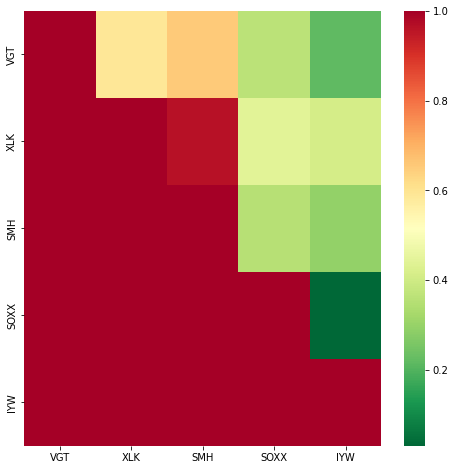

In [87]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
scores, pvalues, pairs = find_cointegrated_pairs(all)
fig, ax = plt.subplots(figsize=(8,8))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
#                 , mask = (pvalues >= 0.05)
                )
print(pairs)

**Our algorithm listed one cointegrated pair: SMH/SOXX. We can analyze their price patterns to make sure there is nothing weird going on.**

In [21]:
S1 = all['Close_smh']
S2 = all['Close_soxx']

score, pvalue, _ = coint(S1, S2)
pvalue

0.030462493165454723

**As we can see, the p-value is less than 0.05, which means SMH and SOXX are indeed cointegrated pairs.**

## Calculating the Ratio

Now we can plot the ratio of the two time series.

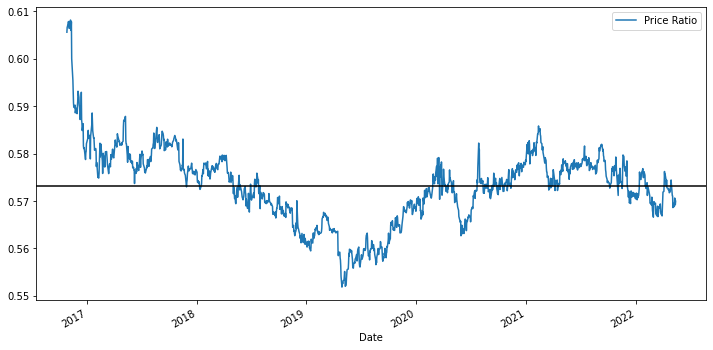

In [22]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim()
plt.legend(['Price Ratio']);

We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

A z-score is the number of standard deviations a datapoint is from the mean. More importantly, the nוmber of standard deviations above or below the population mean is from the raw score. The z-score is calculated by the follow:

$$\mathcal{z}_{i}=\frac{x_{i}-\bar{x}}{s} $$

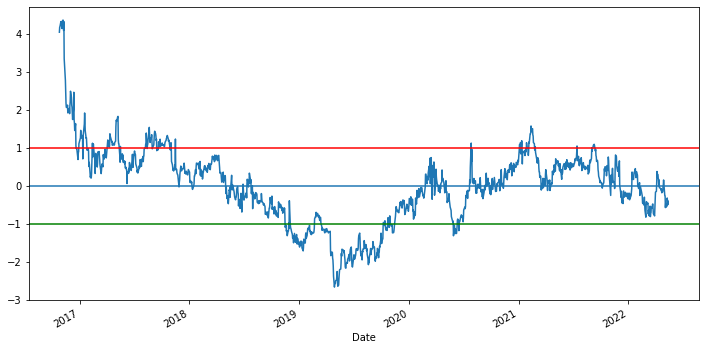

In [23]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim()
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

## Setup rules

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a "sell". The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

* When you buy the ratio, you actully buy S1 and sell S2
* When you sell the ratio, you actully sell S1 and buy S2

##### Rules
* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

#### We will split to train and test, to test our performance later

In [24]:
# create ratios dataframe
ratios = all['Close_smh'] / all['Close_soxx']
# split data 80-20
row_to_split_on = int(len(ratios) * 0.8)
train = ratios[:row_to_split_on]
test = ratios[row_to_split_on:]
print(f"spliting on {row_to_split_on}, train length is: {len(train)}, test length is {len(test)}")

spliting on 1117, train length is: 1117, test length is 280


#### Indicators
Our main hypothessis is that the prices will return to the mean.
Therfore, we will use several indicators and metrics which involve the mean:

**Key point: choosing the look back window.** 
Here we choose randomly.

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

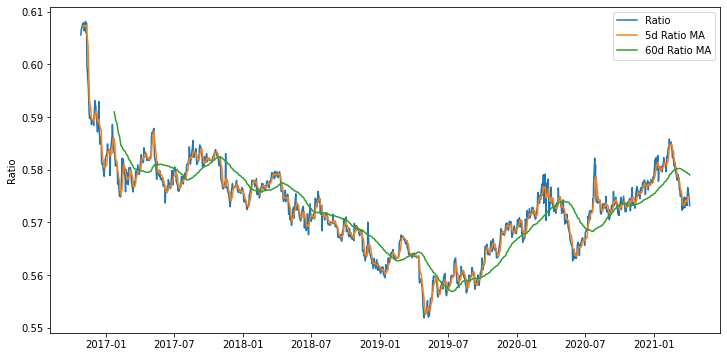

In [25]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

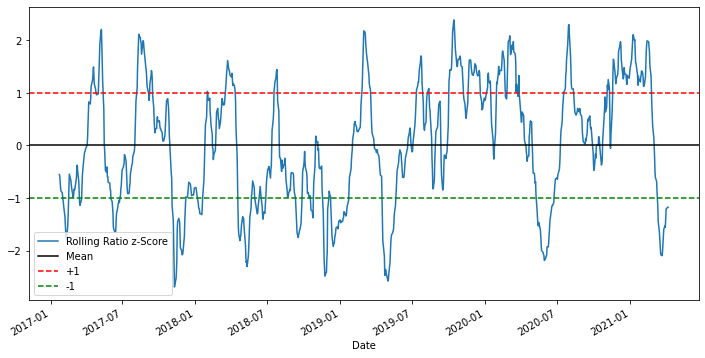

In [26]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

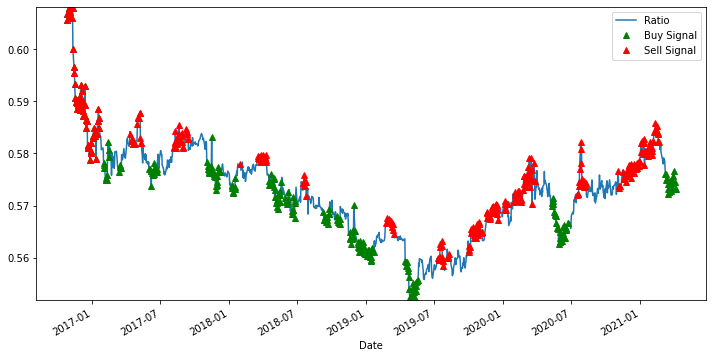

In [27]:
# calculate the metrcis
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60


plt.figure(figsize=(12,6))

train.plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))

plt.xlim()
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

# Calculating results - POC
This is a simple trading strategy, to check if the system works or not.
It is set to buy when the buy signal is presented, and to sell when the sell signal is presented.

In [28]:

# Trade using a simple strategy
def trade(S1, S2, window1, window2, zscore_sell=1):
    zscore_buy = -1 * zscore_sell
    
    # check parameters validity.
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no positions
    start_money_const = 100
    money = start_money_const
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
#         print("z-score is", zscore[i])
        # Buy long if the z-score is < zscore_buy
        if zscore[i] < zscore_buy:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
#             print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Sell short if the z-score is > zscore_sell
        elif zscore[i] > zscore_sell:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
#             print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions and take profits if the z-score between -0.3 and 0.3 
        elif abs(zscore[i]) < 0.3:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#             print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money - start_money_const

In [30]:
smh_train = all['Close_smh'].iloc[:row_to_split_on]
smh_test = all['Close_smh'].iloc[row_to_split_on:]
soxx_train = all['Close_soxx'].iloc[:row_to_split_on]
soxx_test = all['Close_soxx'].iloc[row_to_split_on:]
print(f"Profits on train (in sample) {trade(smh_train, soxx_train, 60, 5)}")
print(f"Profits on test (out sample) {trade(smh_test, soxx_test, 60, 5)}")

Profits on train (in sample) 331.0502373506308
Profits on test (out sample) 275.8430974729092


### As we can see, the simple algorithm works, and it actually has great results

# Creating A Model
We will now improve our strategy by optimizing the profits. </br>
This will be done by brute-force grid-search of the following parameters:</br>
1. look back window of ratio.
2. look back window of standard deviation.
3. z-index

In [34]:
ratio_windows = [i for i in range(1, 90)]
std_windows = [i for i in range(1, 90)]
zindex_windows = [round(i,1) for i in np.arange(0.1, 1.1, 0.1)]
combinations = list(list(product(ratio_windows, std_windows, zindex_windows)))
print(f"number of combinations is: {len(combinations)}")

number of combinations is: 79210


In [35]:
def find_best_combination(combinations):
    best_combination = combinations[0]
    scores = []
    best_score = -100000
    tracking = 0
    for ratio_window, std_window, zindex_window in combinations:
        score = trade(smh_train, soxx_train, ratio_window, std_window, zindex_window)
        if score > best_score:
            best_combination = (ratio_window, std_window, zindex_window)
            best_score = score
        tracking += 1
        if tracking % 1000 == 0:
            print(f"after {tracking} iterations")
        scores.append(score)
    print(f"best combination is: {best_combination} with score: {best_score}")
    return scores

In [36]:
scores = find_best_combination(combinations)

after 1000 iterations
after 2000 iterations
after 3000 iterations
after 4000 iterations
after 5000 iterations
after 6000 iterations
after 7000 iterations
after 8000 iterations
after 9000 iterations
after 10000 iterations
after 11000 iterations
after 12000 iterations
after 13000 iterations
after 14000 iterations
after 15000 iterations
after 16000 iterations
after 17000 iterations
after 18000 iterations
after 19000 iterations
after 20000 iterations
after 21000 iterations
after 22000 iterations
after 23000 iterations
after 24000 iterations
after 25000 iterations
after 26000 iterations
after 27000 iterations
after 28000 iterations
after 29000 iterations
after 30000 iterations
after 31000 iterations
after 32000 iterations
after 33000 iterations
after 34000 iterations
after 35000 iterations
after 36000 iterations
after 37000 iterations
after 38000 iterations
after 39000 iterations
after 40000 iterations
after 41000 iterations
after 42000 iterations
after 43000 iterations
after 44000 iteratio

So we found that the best result is 
* small_ratio=84 days, 
* std & big ratio=26 days, 
* zindex=0.1 </br>

with score: 755.9288366289628

# Results
Now we can plot a graph to test the results we have received

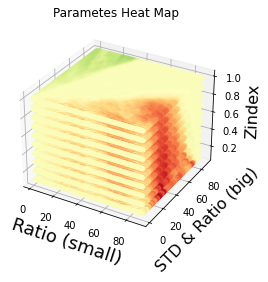

In [59]:
from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()

x = [combination[0] for combination in combinations]
y = [combination[1] for combination in combinations]
z = [combination[2] for combination in combinations]
# ax.scatter(X, Y, Z, c=scores, lw=0, s=20)

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=scores, cmap='RdYlGn_r');
ax.set_xlabel('Ratio (small)', fontsize=18)
ax.set_ylabel('STD & Ratio (big)', fontsize=16)
ax.set_zlabel('Zindex', fontsize=16)
plt.title('Parametes Heat Map')
plt.show()

#### Easy to see that the best parameters are set with high ratio look back window, low STD look back window and pretty much the same for each zindex 

# Sharp Ratio

In [73]:
returns = pd.DataFrame(scores)
mean_log_returns = np.log(returns + 1).mean()
mean_returns = np.exp(mean_log_returns) - 1
std = returns.std()
sharpe_ratio = (mean_returns / std) * np.sqrt(252)
sharpe_ratio[0]

1.4695199681381341

#### Sharpe indeed looks good, points on good in-sample results

# Testing the results
We'll try to see how our assumptions work out of sample. </br>
Remember we divided to train - test (80-20).

In [90]:
profit = trade(smh_test, soxx_test, 84, 26 ,0.1)
profit
# sharp_ratio

16.61415861574403

# Conclusion
Our model didn't hold well out-of-sample.</br>

1. We would need to enlarge the number pairs we are using.
2. We would then calculate more accurate results, based on an average between all the pairs.
3. We would then test all the "test" parts. 